In [ ]:
!python --version

Python 3.10.12


In [ ]:
%pip install pennylane
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib
%pip install cirq
%pip install tensorflow-quantum

ERROR: Could not find a version that satisfies the requirement tensorflow-quantum (from versions: none)
ERROR: No matching distribution found for tensorflow-quantum


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Hyperparameter and directories
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of ansatz layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/drive/My Drive/Projects/QML/QIMP/Data"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(50)           # Seed for NumPy random number generator
tf.random.set_seed(50)       # Seed for TensorFlow random number generator

In [ ]:
# Loading data from MNIST
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

# Qnode decorator with inputs the quantum device we made before and with an inner function of the quantum convolutional kernel
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    # Phi is an array of the 4 input angles, these are the four input pixel values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Randomlayers serving as convolution circuit
    # Might want to see if this is replacable with tensorlayers or mera
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    # Expectation value for projective measurement done in the computational basis
    # Weighted summed values of successive measurements with |0> corresponding to 1 and |1> corresponding to -1
    # From testing the default qubit device can get this a little wrong even if the RY above corresponds to some pauli operator
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

DeviceError: Device qiskit.aer does not exist. Make sure the required plugin is installed.

(<Figure size 500x500 with 1 Axes>, <Axes: >)


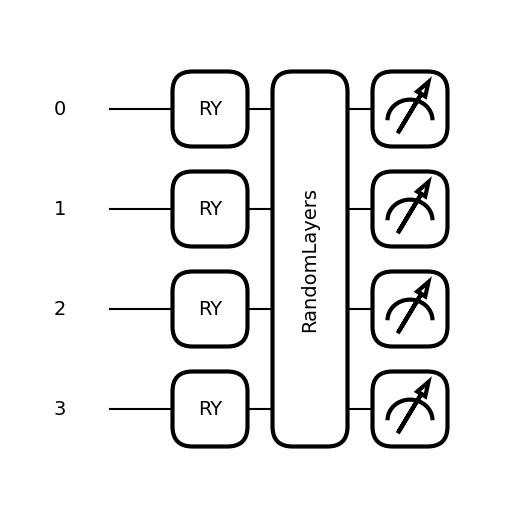

In [ ]:
params = [1, 2, 3, 4]
drawer = qml.draw_mpl(circuit)
print(drawer(params))

In [ ]:
# Quanvolution function
# Image is divided up into 2x2 squares
# Each square is processed through the circuit above
# Each expectation value is mapped to a single 4 channel output "pixel"

def quanv(image):
    """Convolutes the input image with many applications of the same quantum circuit."""
    #14x14 4 channel "pixels"
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
#Pre processing data using quantum kernel
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


In [ ]:
# Actual ML model consisting of 10 node output layer with "softmax" output function (converts output vector to probabilities, shocking we went from probabilities to vectors to probabilities again this is so stupid)
def FCModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
#training of the model on pre processed images (i.e imagine the quanvolution is being applied here)
q_model = FCModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9014 - accuracy: 0.0600 - val_loss: 2.4604 - val_accuracy: 0.1667 - 985ms/epoch - 76ms/step
Epoch 2/30
13/13 - 0s - loss: 2.2937 - accuracy: 0.2400 - val_loss: 2.1785 - val_accuracy: 0.1333 - 103ms/epoch - 8ms/step
Epoch 3/30
13/13 - 0s - loss: 1.9174 - accuracy: 0.4000 - val_loss: 2.1164 - val_accuracy: 0.1333 - 108ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 1.6378 - accuracy: 0.5800 - val_loss: 1.8994 - val_accuracy: 0.3667 - 96ms/epoch - 7ms/step
Epoch 5/30
13/13 - 0s - loss: 1.3819 - accuracy: 0.7600 - val_loss: 1.7733 - val_accuracy: 0.4000 - 156ms/epoch - 12ms/step
Epoch 6/30
13/13 - 0s - loss: 1.2033 - accuracy: 0.8200 - val_loss: 1.7197 - val_accuracy: 0.4667 - 116ms/epoch - 9ms/step
Epoch 7/30
13/13 - 0s - loss: 1.0189 - accuracy: 0.8400 - val_loss: 1.6350 - val_accuracy: 0.5000 - 107ms/epoch - 8ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8877 - accuracy: 0.9200 - val_loss: 1.5680 - val_accuracy: 0.4667 - 158ms/epoch - 12ms/step
Epoch 9/30
13/

In [ ]:
# Classical model trained on just the input images
c_model = FCModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4583 - accuracy: 0.1200 - val_loss: 2.3937 - val_accuracy: 0.1667 - 669ms/epoch - 51ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0238 - accuracy: 0.3200 - val_loss: 2.2057 - val_accuracy: 0.1667 - 77ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7271 - accuracy: 0.6000 - val_loss: 2.0962 - val_accuracy: 0.2333 - 75ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4867 - accuracy: 0.7200 - val_loss: 1.9292 - val_accuracy: 0.3667 - 68ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2742 - accuracy: 0.8400 - val_loss: 1.8051 - val_accuracy: 0.4333 - 65ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1076 - accuracy: 0.9000 - val_loss: 1.7223 - val_accuracy: 0.4667 - 73ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9678 - accuracy: 0.9200 - val_loss: 1.6496 - val_accuracy: 0.5667 - 77ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8505 - accuracy: 0.9600 - val_loss: 1.5796 - val_accuracy: 0.5667 - 65ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

<ipython-input-24-d3631ac5bd10>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


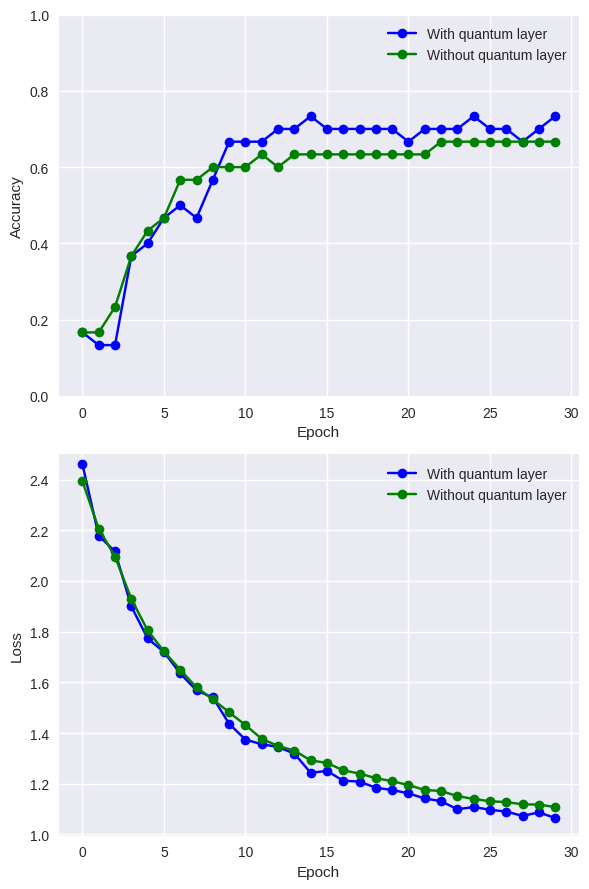

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Training convolutional kernels

In [ ]:
@qml.qnode(dev)
def trainable_quanvolutional_kernel(phi, weights):
    # Encoding of 4 classical input values
    # Phi is an array of the 4 input angles, trainable
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Randomlayers serving as convolution circuit
    # Might want to see if this is replacable with tensorlayers or mera
    StronglyEntanglingLayers(weights=weights, wires=list(range(4)))

    # Measurement producing 4 classical output values
    # Expectation value for projective measurement done in the computational basis
    # Weighted summed values of successive measurements with |0> corresponding to 1 and |1> corresponding to -1
    # From testing the default qubit device can get this a little wrong even if the RY above corresponds to some pauli operator
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]
def cost_function(phi,weights):


In [ ]:
#convert pennylane to cirq

def cirq_circuit(phi, params):
    qubits = cirq.LineQubit.range(4)
    circuit = cirq.Circuit()

     # Encoding of 4 classical input values
    for j in range(4):
        circuit.append(cirq.ry(np.pi * phi[j]).on(qubits[j]))

    # Random layers serving as convolution circuit
    for params in rand_params:
        for j, qubit in enumerate(qubits):
            circuit.append(cirq.ry(params[j]).on(qubit))
        for j in range(3):
            circuit.append(cirq.CNOT(qubits[j], qubits[j+1]))

    # Measurement producing 4 classical output values
    results = []
    for j in range(4):
        circuit.append(cirq.measure(qubits[j], key=f'result{j}'))
        results.append(f'result{j}')
    return circuit, results

In [ ]:
def cirq_quanv(image):
    """Convolutes the input image with many applications of the same quantum circuit."""
    #14x14 4 channel "pixels"
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = cirq_circuit.results(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(cirq_quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(cirq_quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

In [ ]:
#hybrid model
def classical_model():
  model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, acti
        vation="softmax")
    ])

def hybrid_model():



Extras

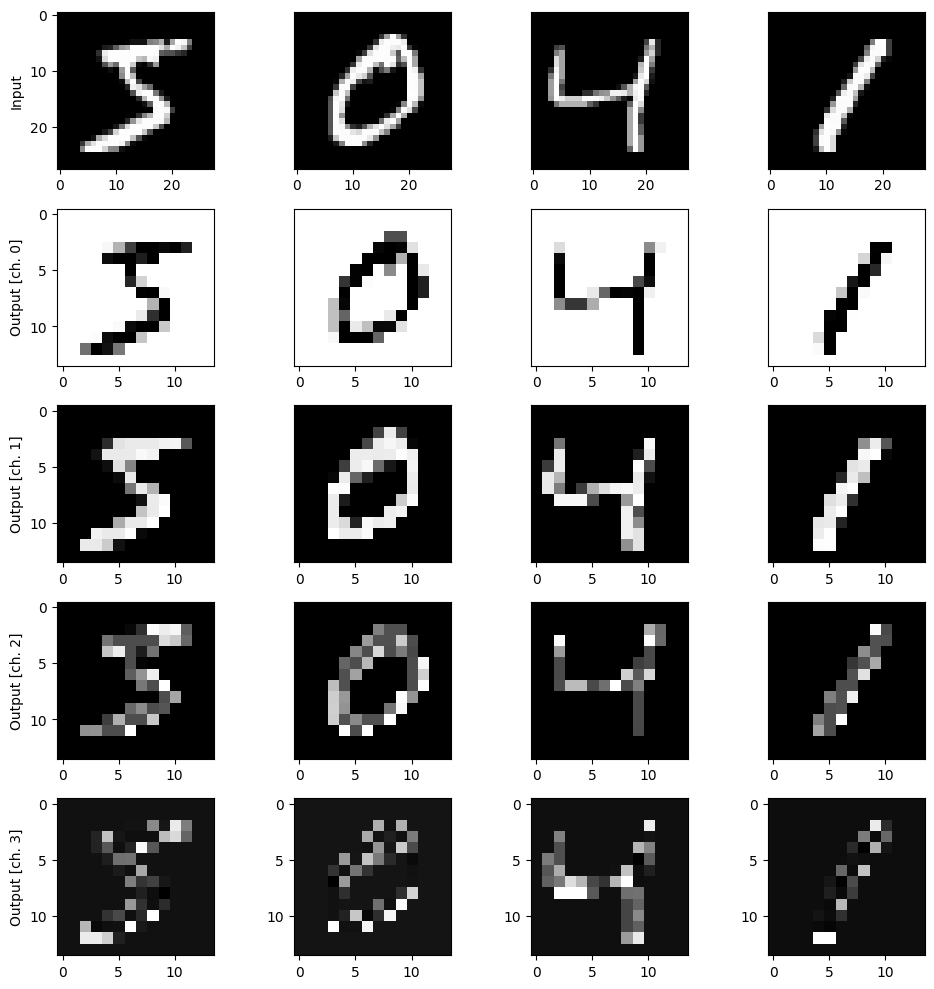

In [ ]:
#Quantum kernel visualization
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Random Tomfoolery

In [ ]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(x):
    qml.RY(x, wires=0)
    #qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

print(circuit(np.pi))

-1.0
